In [39]:
32*25

800

In [40]:
print(batch_obs[:, :, :-1].shape, torch.tensor([tuple(zip(obs[:, -1, 0, 0], obs[:, -1, 0, 1])) for obs in batch_obs]).shape)

batch_coordinates = torch.tensor([tuple(zip(obs[:, -1, 0, 0], obs[:, -1, 0, 1])) for obs in batch_obs])
tmp = []
for coords in batch_coordinates:
    for coord in coords:
        tmp.append(coord)
batch_coordinates = torch.stack(tmp)
batch_coordinates.shape

torch.Size([32, 25, 2, 7, 7]) torch.Size([32, 25, 2])


torch.Size([800, 2])

In [27]:
import numpy as np
import torch

# b, n, c, h, w
# coords in channel 2
batch_obs = np.zeros((32, 25, 3, 7, 7))
batch_obs[0, 0, 2, 0, 0] = 1
batch_obs[0, 0, 2, 0, 1] = 2
batch_obs = torch.tensor(batch_obs)

coordinates = [tuple(zip(obs[:, -1, 0, 0], obs[:, -1, 0, 1])) for obs in batch_obs]
len(coordinates[0]), coordinates[0]

(25,
 ((tensor(1., dtype=torch.float64), tensor(2., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64)),
  (tensor(0., d

In [6]:
goals = [[(343, 0)], [(530, 0)], [(910, 0)], [(356, 0)], [(354, 0)], [(1276, 0)], [(346, 0)], [(66, 0)], [(62, 0)], [(974, 0)], [(423, 0)], [(1348, 0)], [(167, 0)], [(1177, 0)], [(998, 0)], [(530, 0)], [(237, 0)], [(243, 0)], [(169, 0)], [(1174, 0)], [(801, 0)], [(61, 0)], [(1002, 0)], [(1350, 0)], [(607, 0)], [(1271, 0)], [(975, 0)], [(527, 0)], [(980, 0)], [(1276, 0)], [(1004, 0)], [(894, 0)], [(342, 0)], [(72, 0)], [(820, 0)], [(266, 0)], [(1355, 0)], [(1174, 0)], [(1434, 0)], [(1365, 0)], [(246, 0)], [(332, 0)], [(812, 0)], [(360, 0)], [(1080, 0)], [(1440, 0)], [(521, 0)], [(1264, 0)], [(1254, 0)], [(697, 0)], [(538, 0)], [(530, 0)], [(330, 0)], [(75, 0)], [(357, 0)], [(884, 0)], [(975, 0)], [(903, 0)], [(1358, 0)], [(54, 0)]]

col = 46
[[(g[0]//col + 1, g[0]%col + 1) for g in goal] for goal in goals]

[[(8, 22)],
 [(12, 25)],
 [(20, 37)],
 [(8, 35)],
 [(8, 33)],
 [(28, 35)],
 [(8, 25)],
 [(2, 21)],
 [(2, 17)],
 [(22, 9)],
 [(10, 10)],
 [(30, 15)],
 [(4, 30)],
 [(26, 28)],
 [(22, 33)],
 [(12, 25)],
 [(6, 8)],
 [(6, 14)],
 [(4, 32)],
 [(26, 25)],
 [(18, 20)],
 [(2, 16)],
 [(22, 37)],
 [(30, 17)],
 [(14, 10)],
 [(28, 30)],
 [(22, 10)],
 [(12, 22)],
 [(22, 15)],
 [(28, 35)],
 [(22, 39)],
 [(20, 21)],
 [(8, 21)],
 [(2, 27)],
 [(18, 39)],
 [(6, 37)],
 [(30, 22)],
 [(26, 25)],
 [(32, 9)],
 [(30, 32)],
 [(6, 17)],
 [(8, 11)],
 [(18, 31)],
 [(8, 39)],
 [(24, 23)],
 [(32, 15)],
 [(12, 16)],
 [(28, 23)],
 [(28, 13)],
 [(16, 8)],
 [(12, 33)],
 [(12, 25)],
 [(8, 9)],
 [(2, 30)],
 [(8, 36)],
 [(20, 11)],
 [(22, 10)],
 [(20, 30)],
 [(30, 25)],
 [(2, 9)]]

In [10]:
row, col = [int(i) for i in "33,46".strip().split(',')]
row, col

"maps/kiva.map".split('.')[0]

'maps/kiva'

In [1]:
import torch
from Model import QNetwork

# Load your trained model
model = QNetwork()  # Replace with your actual model class
model.load_state_dict(torch.load('./results/warehouse/q_net_model/q_net_1420000.pth'))
# model.eval()

# Convert to TorchScript
scripted_model = torch.jit.script(model)

# Save the TorchScript model
scripted_model.save("model.pt")

In [1]:
x = [1,2,3]
x.pop(0)
print(x)

[2, 3]


In [7]:
import torch

x = torch.tensor([1])

y = torch.tensor(2)

stacked = torch.stack([x, y])

RuntimeError: stack expects each tensor to be equal size, but got [1] at entry 0 and [] at entry 1

In [ ]:
x = [1,2,3,4,5,6]

int(x.index(1) > x.index(2)), int(x.index(2) > x.index(1))

(0, 1)

# reward function

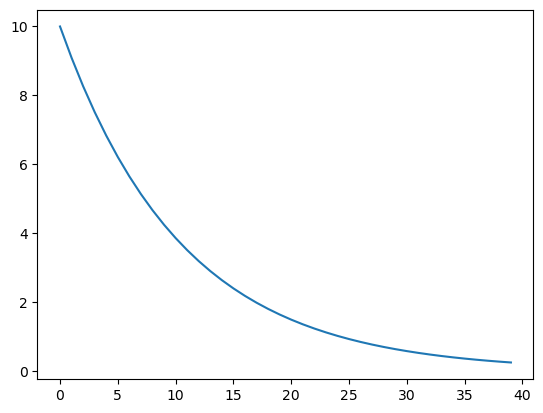

In [18]:
import numpy as np
import matplotlib.pyplot as plt


rew = range(40)
a = 1.1

# plot a^r
plt.plot([(a ** -r)*10 for r in rew])

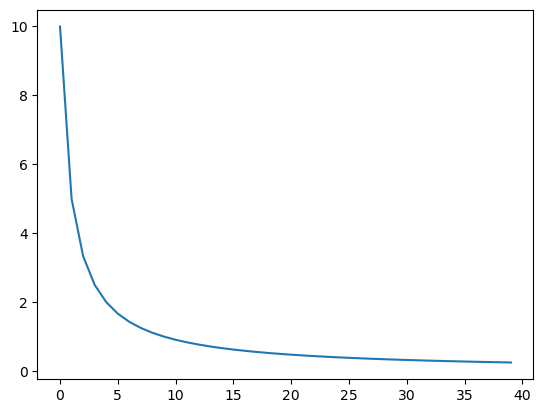

In [17]:
plt.plot([10 / (r + 1) for r in rew])

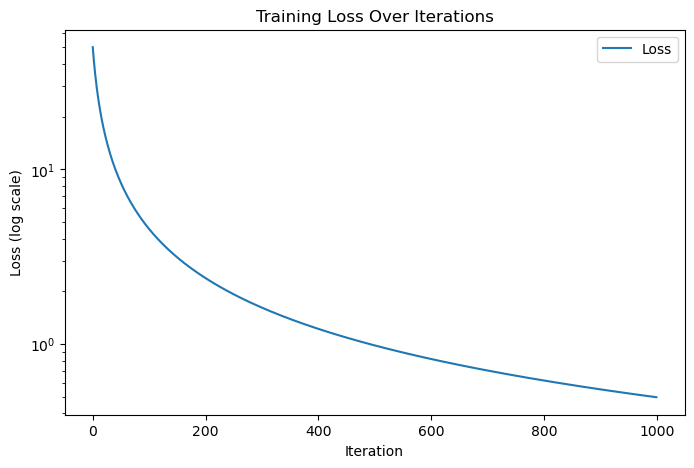

In [21]:
iterations = range(1000)
losses = [50 / (1 + 0.1*i) for i in iterations]  # example decreasing losses

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses, label='Loss')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.show()

# saving files if dir does not exist yet

In [2]:
import numpy as np
import os

x = np.array([1, 2, 3, 4, 5])

# check if directory exists
if not os.path.exists('test/test1'):
    os.makedirs('test/test1')

if not os.path.exists('test/test1/x.npy'):
    np.save('test/test1/x.npy', x)

# Generate Warehouse map

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the colormap
cmap = ListedColormap(["white", "black", "yellow", "red"])

In [129]:
def generate_warehouse(rows, cols, num_agents, num_goals, seed=None):
    np.random.seed(seed)

    people = np.array(
        [[2,2,0,2,2],
        [2,2,0,2,2],
        [2,2,0,2,2],
        ]
    )

    shelves = np.array(
        [[3]*10,
        [1]*10,
        [3]*10,
        ]
    )

    hall_ver = np.array(
        [[0],
        [0],
        [0],
        ]
    )

    row = people

    for j in range(cols):
        row = np.concatenate((row, hall_ver, shelves), axis=1)

    row = np.concatenate((row, hall_ver, people), axis=1)

    hall_hor = np.array(
        [[0]*len(row[0])]
    )

    warehouse = row

    for i in range(rows-1):
        warehouse = np.concatenate((warehouse, hall_hor, row), axis=0)

    # pad the warehouse with a row of zeros
    warehouse = np.pad(warehouse, 1, 'constant')

    plt.imshow(warehouse, cmap=cmap, vmin=0, vmax=3)


    # generate random starts and goals
    station_locs = np.where(warehouse == 2)
    station_locs = np.array(list(zip(station_locs[0], station_locs[1])))

    # get possible goal locations
    shelves_locs = np.where(warehouse == 3)
    shelves_locs = np.array(list(zip(shelves_locs[0], shelves_locs[1])))

    # generate randomly selected start and goal locations
    np.random.shuffle(station_locs)
    np.random.shuffle(shelves_locs)

    start_locs = station_locs[:num_agents]

    rng = np.random.default_rng()
    rng.shuffle(shelves_locs)
    goal_locs = np.array([[i] for i in shelves_locs[:num_agents].copy()])
    for i in range(num_goals):
        rng.shuffle(shelves_locs)
        new_shelves = shelves_locs[:num_agents].copy()
        goal_locs = np.concatenate((goal_locs, new_shelves[:, None, :]), axis=1)

    return warehouse, start_locs, goal_locs

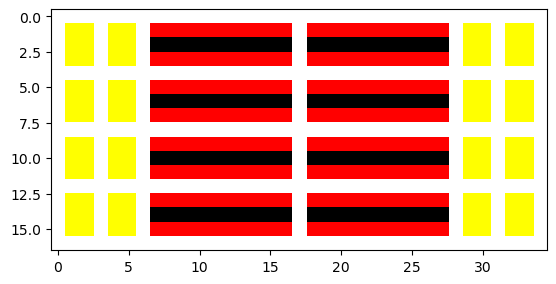

In [134]:
ROWS = 4
COLS = 2

warehouse, start_locs, goal_locs = generate_warehouse(ROWS, COLS, num_agents=2, num_goals=15, seed=0)

# Softmax

In [20]:
import torch
import torch.nn.functional as F

import numpy as np

In [25]:
F.softmax(torch.tensor([[-0.039,  0.135],
[-0.215,  0.362],
[ 0.577, -0.623],
[-0.323,  0.443],
[ 0.473, -0.558],
[ 0.588, -0.609],
[-0.031, -0.095],
[-0.049, -0.074],
[-0.013, -0.093]]), dim=1)*100

tensor([[45.6609, 54.3391],
        [35.9623, 64.0377],
        [76.8525, 23.1475],
        [31.7345, 68.2655],
        [73.7110, 26.2890],
        [76.7991, 23.2009],
        [51.5995, 48.4005],
        [50.6250, 49.3750],
        [51.9989, 48.0011]])

In [24]:
F.softmax(torch.tensor([[-0.086,  0.217],
[-0.205,  0.378],
[ 0.57, -0.59],
[-0.251,  0.4],
[ 0.527, -0.564],
[ 0.609, -0.601],
[ 0.046, -0.136],
[ 0.012, -0.096],
[ 0.038, -0.103]]), dim=1)*100

tensor([[42.4824, 57.5176],
        [35.8243, 64.1757],
        [76.1333, 23.8667],
        [34.2764, 65.7236],
        [74.8570, 25.1430],
        [77.0299, 22.9701],
        [54.5375, 45.4625],
        [52.6974, 47.3026],
        [53.5192, 46.4808]])

In [13]:
starts = [(1,2),(2,3),(3,4)]
goals = [[(3,3),(4,4),(5,5)]]

x = {}

In [15]:
x[tuple(starts)] = {}

In [16]:
x[tuple(starts)][tuple([tuple(x) for x in goals])] = 0

In [17]:
x[tuple(starts)][tuple([tuple(x) for x in goals])]

0

# CONFIG FILE

In [6]:
import yaml

# Load the YAML config file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access values
BATCH_SIZE = config["training"]
BATCH_SIZE

{'BATCH_SIZE': 32,
 'LAMBDA': 1,
 'LR': '1e-4',
 'BUFFER_SIZE': 10000,
 'TRAIN_STEPS': '1e10',
 'N_ACTIONS': 2}

# FOV

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
num_agents = 3
obs_radius = 7

obs = np.zeros((num_agents, 6, 2*obs_radius+1, 2*obs_radius+1), dtype=bool)

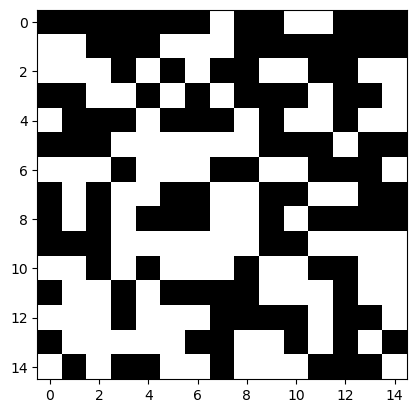

In [50]:
map_size = (15, 15)
grid_map = np.random.randint(2, size=map_size)
plt.imshow(grid_map, cmap='gray_r')

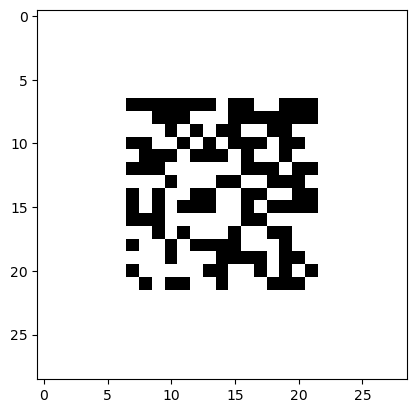

In [51]:
obstacle_map = np.pad(grid_map, obs_radius, 'constant', constant_values=0)
plt.imshow(obstacle_map, cmap='gray_r')

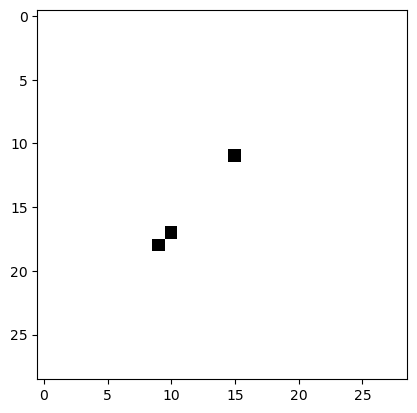

In [52]:
agents_pos = np.random.randint(1, map_size[0]-1, size=(num_agents, 2))
agent_map = np.zeros((map_size), dtype=bool)
agent_map[agents_pos[:,0], agents_pos[:,1]] = 1
agent_map = np.pad(agent_map, obs_radius, 'constant', constant_values=0)
plt.imshow(agent_map, cmap='gray_r')

In [53]:
# 1. neighboring agents
# 2. obstacle_map
# 3. heuri_map

for i, agent_pos in enumerate(agents_pos):
    x, y = agent_pos
    obs[i, 0] = agent_map[x:x+2*obs_radius+1, y:y+2*obs_radius+1]
    obs[i, 0, obs_radius, obs_radius] = 0
    obs[i, 1] = obstacle_map[x:x+2*obs_radius+1, y:y+2*obs_radius+1]
    # obs[i, 2:] = heuri_map[i, :, x:x+2*obs_radius+1, y:y+2*obs_radius+1]

In [54]:
agents_pos[0]

array([4, 8])

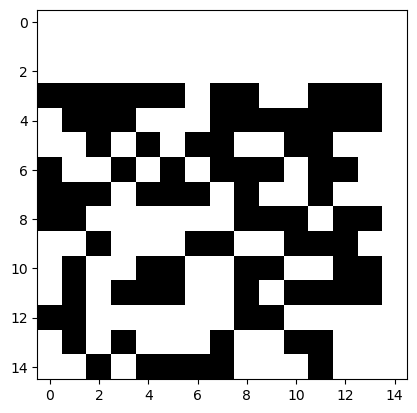

In [57]:
plt.imshow(obs[0,1], cmap='gray_r')